### ECE 685D - Fall 2020
## Problem Set 4 

> J. Felipe Montano-Campos

**Problem 1: Classification with Convolutional Neural Networks** 

In [4]:
import os
os.chdir('/Users/felipemontanocampos/Dropbox/Third Semester/Deep Learning/Homerowks/HW4/Data')

airplane


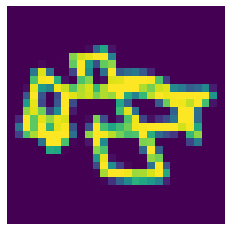

basket


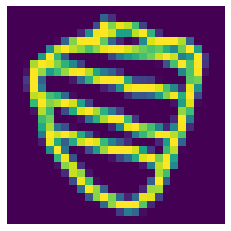

basketball


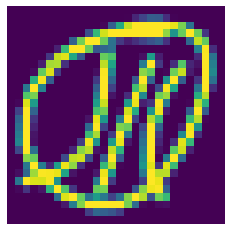

bed


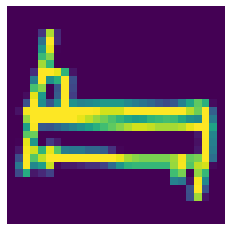

bus


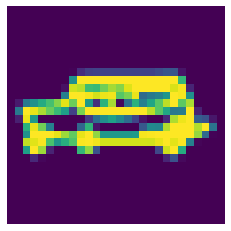

calculator


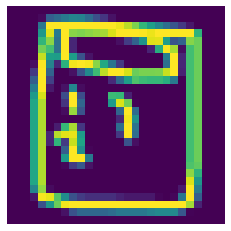

cookie


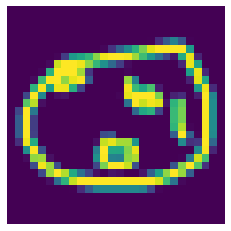

eyeglasses


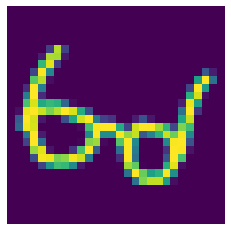

mushroom


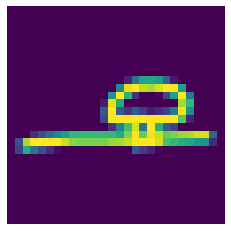

pizza


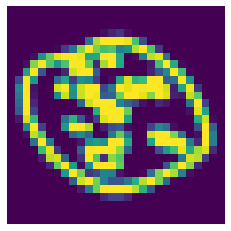

In [5]:
import numpy as np
import random

#Labels to work with
labels= ["airplane", "basket", "basketball", "bed", "bus", "calculator", "cookie", "eyeglasses", "mushroom", "pizza"]

#Get the data
data = {}

for label in labels:
    data[label] = np.load("full_numpy_bitmap_"+label+".npy")

sample_size_train = 6000
sample_size_test = 1000

for label in labels:
    rows_id = random.sample(range(0,data[label].shape[0]-1), sample_size_train+sample_size_test)
    data[label] = data[label][rows_id, :] 

training_set=  {}
train_label = {}
test_set = {}
test_label = {}
i = 0
for label in labels:
    training_set[label] =  data[label][0:sample_size_train, :]
    train_label[label] = np.full((training_set[label].shape[0]), i)
    test_set[label] =  data[label][sample_size_train:, :]
    test_label[label] = np.full((test_set[label].shape[0]), i)
    i +=1

#Plot some random observations
import matplotlib.pyplot as plt
for label in labels:
    print(label)
    plot = training_set[label][23]
    plot_pixels = plot.reshape(28,28)
    plt.imshow(plot_pixels)
    plt.axis('off')
    plt.show()

In [6]:
# Final Data
training_set_v = np.vstack([training_set["airplane"],training_set["basket"],training_set[ "basketball"],training_set["bed"],training_set["bus"],training_set["calculator"],training_set["cookie"],training_set["eyeglasses"],training_set["mushroom"],training_set["pizza"]])
training_label_v = np.hstack([train_label["airplane"],train_label["basket"],train_label[ "basketball"],train_label["bed"],train_label["bus"],train_label["calculator"],train_label["cookie"],train_label["eyeglasses"],train_label["mushroom"],train_label["pizza"]])
test_set_v =  np.vstack([test_set["airplane"],test_set["basket"],test_set[ "basketball"],test_set["bed"],test_set["bus"],test_set["calculator"],test_set["cookie"],test_set["eyeglasses"],test_set["mushroom"],test_set["pizza"]])
test_label_v =  np.hstack([test_label["airplane"],test_label["basket"],test_label[ "basketball"],test_label["bed"],test_label["bus"],test_label["calculator"],test_label["cookie"],test_label["eyeglasses"],test_label["mushroom"],test_label["pizza"]])


In [7]:
#Pre process - Data
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
scaler = MinMaxScaler()
scaler.fit(training_set_v)
training_set_v = scaler.transform(training_set_v)
scaler.fit(test_set_v)
test_set_v = scaler.transform(test_set_v)

In [8]:
#Unflatten Arrays
training = []
for i in range(training_set_v.shape[0]):
    image = training_set_v[i]
    image_matrix = image.reshape(28,28)
    image_matrix = np.expand_dims(image_matrix, axis=0)
    training.append(image_matrix)  
training = np.array(training)
test = []
for i in range(test_set_v.shape[0]):
    image = test_set_v[i]
    image_matrix = image.reshape(28,28)
    image_matrix = np.expand_dims(image_matrix, axis=0)
    test.append(image_matrix)
test = np.array(test)

In [9]:
#Import Files
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#My training and test set to pytorch
X, y = torch.from_numpy(np.array(training)).float(), torch.from_numpy(np.array(training_label_v)).long()
Xtest, ytest = torch.from_numpy(np.array(test)).float(), torch.from_numpy(np.array(test_label_v)).long()


In [11]:
#Define the convolution Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out    


In [12]:
#Param        
num_epochs = 10
batch_size = 250
learning_rate = 0.001
train_acc = []
test_acc = []
loss_list = []
#Set the model, the loss criterio and the optimizer
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model


for epoch in range(num_epochs+1)[1:]:
    permutation = torch.randperm(X.size()[0])
    for i in range(0,X.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X[indices], y[indices]
        #Forward pass
        y_hat = model(batch_x)
        loss = criterion(y_hat, batch_y)
        loss_list.append(loss.item())
        #Backprop and perform Adam optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Track Training accuracy
    y_hat = model(X)
    total = y.size(0)
    _, predicted = torch.max(y_hat.data, 1)
    correct = (predicted == y).sum().item()
    accuracy = correct / total
    train_acc.append(accuracy)
    #Test Accuracy
    y_hat_test = model(Xtest)
    total = ytest.size(0)
    _, predicted = torch.max(y_hat_test.data, 1)
    correct = (predicted == ytest).sum().item()
    accuracy_test = correct / total
    test_acc.append(accuracy_test)        
    print("Epoch Number: "+str(epoch)+" | Training Accuracy: "+str(accuracy)+" | Test Accuracy: "+str(accuracy_test) )


Epoch Number: 1 | Training Accuracy: 0.8711166666666667 | Test Accuracy: 0.8658
Epoch Number: 2 | Training Accuracy: 0.90245 | Test Accuracy: 0.8928
Epoch Number: 3 | Training Accuracy: 0.91355 | Test Accuracy: 0.9032
Epoch Number: 4 | Training Accuracy: 0.9188666666666667 | Test Accuracy: 0.9019
Epoch Number: 5 | Training Accuracy: 0.9251 | Test Accuracy: 0.9124
Epoch Number: 6 | Training Accuracy: 0.9294333333333333 | Test Accuracy: 0.9131
Epoch Number: 7 | Training Accuracy: 0.93235 | Test Accuracy: 0.9109
Epoch Number: 8 | Training Accuracy: 0.9324666666666667 | Test Accuracy: 0.9123
Epoch Number: 9 | Training Accuracy: 0.9348666666666666 | Test Accuracy: 0.9126
Epoch Number: 10 | Training Accuracy: 0.9362166666666667 | Test Accuracy: 0.9148


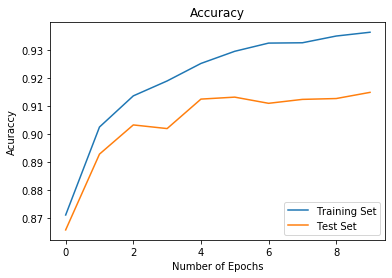

In [17]:
##Plot accuracy

plt.plot(list(range(num_epochs)),train_acc, label = "Training Set")
plt.plot(list(range(num_epochs)),test_acc, label = "Test Set" )
plt.title('Accuracy')
plt.ylabel('Acuraccy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()

**Problem 2: Feature Extraction Using Autoencoder** 

**Set-up**

In [18]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [19]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

**AE-based feature extration**

In [21]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features=64)
        self.enc3 = nn.Linear(in_features=64, out_features=12)
        self.enc4 = nn.Linear(in_features=12, out_features=3)
        # decoder 
        self.dec1 = nn.Linear(in_features=3, out_features=12)
        self.dec2 = nn.Linear(in_features=12, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = self.enc4(x)
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.tanh(self.dec4(x))
        return x

In [22]:
##Define parameters
        
learning_rate = 0.001
net = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr= learning_rate)
print(net)
num_epochs = 40 
#Train the model
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data 
#        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        feat_reduc = net(img)
        loss = criterion(feat_reduc, img)
        loss.backward()
        optimizer.step()

Autoencoder(
  (enc1): Linear(in_features=784, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=64, bias=True)
  (enc3): Linear(in_features=64, out_features=12, bias=True)
  (enc4): Linear(in_features=12, out_features=3, bias=True)
  (dec1): Linear(in_features=3, out_features=12, bias=True)
  (dec2): Linear(in_features=12, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=784, bias=True)
)


/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [23]:
#Training set 
net.eval()
train_x = train_dataset.data
train_x = train_x.view(train_x.size(0),-1)
train_y = train_dataset.targets
train_x_extracted = net(train_x.float())
train_x = train_x.detach().cpu().numpy()
train_y = train_y.detach().cpu().numpy()
train_x_extracted = train_x_extracted.float().detach().cpu().numpy()

#Test Set
net.eval()
test_x = test_dataset.data
test_x = test_x.view(test_x.size(0),-1)
test_y = test_dataset.targets
test_x_extracted = net(test_x.float())
test_x = test_x.detach().cpu().numpy()
test_y = test_y.detach().cpu().numpy()
test_x_extracted = test_x_extracted.detach().cpu().numpy()

In [24]:
#Estimate accuracies

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Using MNSIT features

#Features
clf = LogisticRegression(random_state=0, max_iter = 40).fit(train_x, train_y)
predict_train_x = clf.predict(train_x)
predict_test_y = clf.predict(test_x)

train_accuracy = accuracy_score(train_y,predict_train_x)
test_accuracy = accuracy_score(test_y, predict_test_y)

print("Accuracies using not processed Features:")
print("Training Accuracy:"+str(train_accuracy))
print("Test Accuracy:"+str(test_accuracy))



#Extracted Features

clf = LogisticRegression(random_state=0, max_iter = 40).fit(train_x_extracted, train_y)
predict_train_x_extracted = clf.predict(train_x_extracted)
predict_test_y_extracted = clf.predict(test_x_extracted)

train_accuracy_extracted = accuracy_score(train_y,predict_train_x_extracted)
test_accuracy_extracted = accuracy_score(test_y, predict_test_y_extracted)

print("Accuracies using Extracted Features:")
print("Training Accuracy:"+str(train_accuracy_extracted))
print("Test Accuracy:"+str(test_accuracy_extracted))



/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracies using not processed Features:
Training Accuracy:0.9291333333333334
Test Accuracy:0.9176


/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/felipemontanocampos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracies using Extracted Features:
Training Accuracy:0.8455833333333334
Test Accuracy:0.8316
